In [3]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-02-12 12:07:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 108.177.13.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   163MB/s    in 1.0s    

2024-02-12 12:07:49 (163 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [6]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 2 directories and 0 images in '10_food_classes_10_percent
There are 10 directories and 0 images in '10_food_classes_10_percent/test
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon
There are 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [49]:
import datetime

def create_tensorflow_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

In [46]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [33]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [34]:
IMAGE_SHAPE + (3, )

(224, 224, 3)

In [35]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE + (3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

In [36]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [37]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [38]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [42]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorflow_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnet50V2"
                                                                        )])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20240212-150220
Epoch 1/5
24/24 [==============================] - 566s 24s/step - loss: 0.2230 - accuracy: 0.9773 - val_loss: 0.6467 - val_accuracy: 0.7908
Epoch 2/5
24/24 [==============================] - 563s 24s/step - loss: 0.1900 - accuracy: 0.9800 - val_loss: 0.6389 - val_accuracy: 0.7952
Epoch 3/5
24/24 [==============================] - 563s 24s/step - loss: 0.1706 - accuracy: 0.9867 - val_loss: 0.6273 - val_accuracy: 0.7980
Epoch 4/5
24/24 [==============================] - 518s 22s/step - loss: 0.1483 - accuracy: 0.9880 - val_loss: 0.6348 - val_accuracy: 0.7904
Epoch 5/5
24/24 [==============================] - 563s 24s/step - loss: 0.1261 - accuracy: 0.9907 - val_loss: 0.6211 - val_accuracy: 0.7984


In [43]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

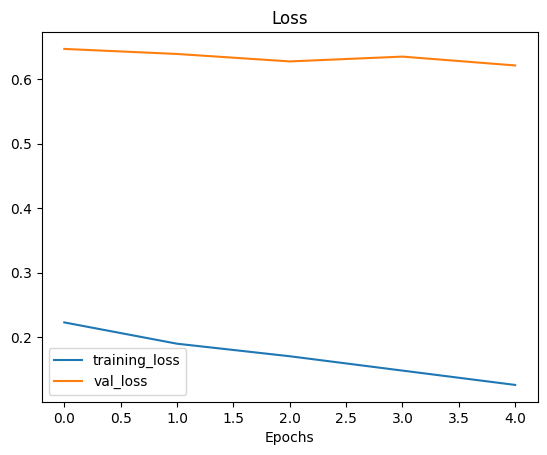

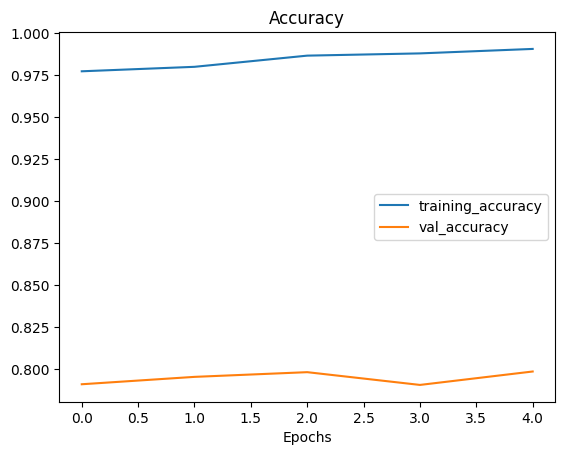

In [44]:
plot_loss_curves(resnet_history)

In [53]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorflow_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to : tensorflow_hub/efficientnetb0/20240212-163415
Epoch 1/5
24/24 [==============================] - 244s 10s/step - loss: 1.8173 - accuracy: 0.4693 - val_loss: 1.2630 - val_accuracy: 0.7392
Epoch 2/5
24/24 [==============================] - 258s 11s/step - loss: 1.0404 - accuracy: 0.7813 - val_loss: 0.8443 - val_accuracy: 0.8164
Epoch 3/5
24/24 [==============================] - 228s 10s/step - loss: 0.7458 - accuracy: 0.8333 - val_loss: 0.6795 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 236s 10s/step - loss: 0.6033 - accuracy: 0.8573 - val_loss: 0.5985 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 255s 11s/step - loss: 0.5072 - accuracy: 0.8893 - val_loss: 0.5455 - val_accuracy: 0.8596


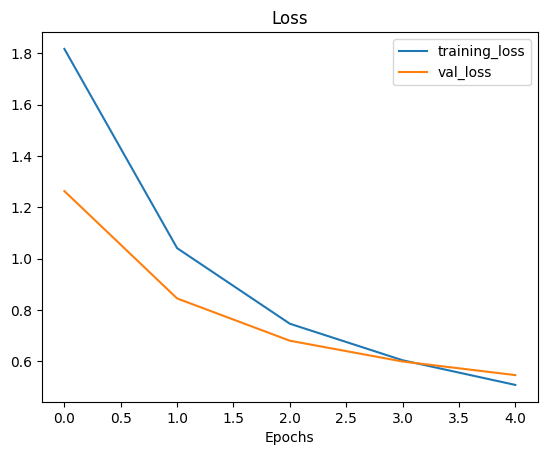

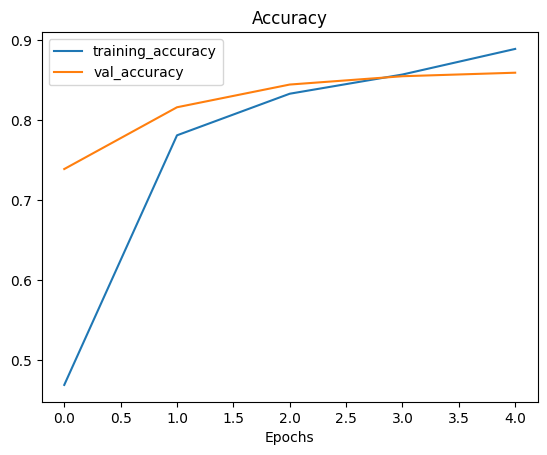

In [54]:
plot_loss_curves(efficientnet_history)

In [55]:
efficientnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [56]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [57]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2024-02-12 17:17:22.385856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 17:17:22.385994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 17:17:22.389406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 17:17:24.598772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb